In [4]:
from bertviz import model_view, head_view
from transformers import *
import numpy as np
import pprint

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel
import torch

In [5]:
#tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-v1.1')
#config = AutoConfig.from_pretrained('dmis-lab/biobert-v1.1',  output_hidden_states=True, output_attentions=True)  
#model = AutoModel.from_pretrained('dmis-lab/biobert-v1.1', config=config)

In [6]:
#import pickle
#pickle.dump(tokenizer, open("tokenizer.bin", "wb"))
#pickle.dump(config, open("config.bin", "wb"))
#pickle.dump(model, open("model.bin", "wb"))

In [7]:
import xml.etree.ElementTree as ET
import pandas as pd
import trec
import pickle

Queries = "../Data/topics-2014_2015-summary.topics"
Qrels = "../Data/qrels-clinical_trials.txt"
with open(Queries, 'r') as queries_reader:
    txt = queries_reader.read()

root = ET.fromstring(txt)

cases = {}
for query in root.iter('TOP'):
    q_num = query.find('NUM').text
    q_title = query.find('TITLE').text
    cases[q_num] = q_title
    
eval = trec.TrecEvaluation(cases, Qrels)

tokenizer = pickle.load(open("tokenizer.bin", "rb"))
config = pickle.load(open("config.bin", "rb"))
model = pickle.load(open("model.bin", "rb"))

docs_brief_title = pickle.load( open( "../Data/docs_brief_title.bin", "rb" ) )
docs_detailed_desc = pickle.load( open( "../Data/docs_detailed_desc.bin", "rb" ) )
docs_brief_summary = pickle.load( open( "../Data/docs_brief_summary.bin", "rb" ) )
docs_criteria = pickle.load( open( "../Data/docs_criteria.bin", "rb" ) )

ids_brief_title = pickle.load( open( "../Data/ids_brief_title.bin", "rb" ) )
ids_detailed_desc = pickle.load( open( "../Data/ids_detailed_desc.bin", "rb" ) )
ids_brief_summary = pickle.load( open( "../Data/ids_brief_summary.bin", "rb" ) )
ids_criteria = pickle.load( open( "../Data/ids_criteria.bin", "rb" ) )
ids = pickle.load( open( "../Data/doc_ids.bin", "rb" ) )
docs = [docs_brief_title, docs_detailed_desc, docs_brief_summary, docs_criteria]
doc_ids_fields = [ids_brief_title, ids_detailed_desc, ids_brief_summary, ids_criteria]

In [8]:
def select_pair_qydoc_relevant():
    qydocpairs_2 = (eval.all_relevancies()[eval.all_relevancies()['rel']==2])
    query_id = qydocpairs_2.iloc[[-2]]['query_id'].values[0]
    doc_id = qydocpairs_2.iloc[[-2]]['docid'].values[0]
    query = cases[str(query_id)]
    doc = ids_detailed_desc.index(str(doc_id))
    doc = docs_detailed_desc[doc]
    return query, doc, query_id, doc_id

In [9]:
def select_pair_qydoc_non_relevant():
    qydocpairs_2 = eval.all_relevancies()
    #print(qydocpairs_2.iloc[[3763]]['rel'].values[0])
    # selected by hand to have the same query but with 0 relevance
    query_id = qydocpairs_2.iloc[[3761]]['query_id'].values[0]
    doc_id = qydocpairs_2.iloc[[3761]]['docid'].values[0]
    query = cases[str(query_id)]
    doc = ids_detailed_desc.index(str(doc_id))
    doc = docs_detailed_desc[doc]
    return query, doc, query_id, doc_id

In [10]:
query, doc, query_id, doc_id = select_pair_qydoc_relevant()
non_relevant = False
#query, doc, query_id, doc_id = select_pair_qydoc_non_relevant()
#non_relevant = True
print("Query id:", query_id, "Doc id:", doc_id)

Query id: 20157 Doc id: NCT02614443


In [11]:
CLS_token = "[CLS]"
SEP_token = "[SEP]"

In [12]:
# inspired by: https://github.com/nyu-dl/dl4marco-bert/blob/e6fdc7fd13ade0a8d7cde8c232529c8542a93549/tokenization.py

def convert_to_bert_input(sentences, max_seq_length, tokenizer, add_cls, return_tensors="pt"):

    # The convention in BERT is:
    # (a) For sequence pairs:
    #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
    #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
    # (b) For single sequences:
    #  tokens:   [CLS] the dog is hairy . [SEP]
    #  type_ids: 0   0   0   0  0     0 0
    #
    # Where "type_ids" are used to indicate whether this is the first
    # sequence or the second sequence. The embedding vectors for `type=0` and
    # `type=1` were learned during pre-training and are added to the wordpiece
    # embedding vector (and position vector). 
    #
    # For classification tasks, the first vector (corresponding to [CLS]) is
    # used as as the "sentence vector".
    
    # Tokenize both sentences
    sentences_tokens = [tokenizer.tokenize(s + SEP_token) for s in sentences]
    
    # Combine sentences tokens on a single list
    tokens = sum(sentences_tokens, [])
    
    if add_cls:
        tokens = [CLS_token] + tokens

    # Create Token type ids tensors
    token_type_ids = [[i]*len(s) for i, s in enumerate(sentences_tokens)] # Acount for the SEP token we've just added
    token_type_ids = [0] + sum(token_type_ids, []) # CLS + The whole token_type_ids flattened

    # Remove tokens if max_seq_length is exceeded
    # Account for [CLS] and [SEP] with "- 3"
    if len(tokens) > max_seq_length - 3:
        tokens = tokens[:max_seq_length - 4] + [tokens[-1]] # keep SEP token
        token_type_ids = token_type_ids[:max_seq_length - 3]

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    #print(input_ids)
    
     # Create Attention mask tensor -> Which tokens should BERT consider
    attention_mask = [1]*len(tokens)
    
    if return_tensors == "pt":
        input_ids = torch.tensor([input_ids], dtype=torch.long)
        token_type_ids = torch.tensor([token_type_ids], dtype=torch.long)
        attention_mask = torch.tensor([attention_mask], dtype=torch.long)
    
    data = {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_mask
    }

    return data

In [15]:
sentences = [query, doc]
inputs_query_passages = convert_to_bert_input(sentences=sentences, max_seq_length=512, tokenizer=tokenizer, add_cls=True)
#pprint.pprint(inputs_query_passages)


In [16]:
input_ids = inputs_query_passages['input_ids']
bert_input = tokenizer.decode(input_ids[0])
print(bert_input)

[CLS] A 22 year old female presents with changes in appetite and sleeping, fatigue, diminished ability to think or concentrate, anhedonia and feelings of guilt. [SEP] Depression, anxiety and stress are among the primary causes of disease rates worldwide and are the most prevalent mental health problems in the U. S. Each is associated with significant economic, personal, intrapersonal and societal losses including lower quality of life and increased mortality. Depression, Anxiety and Stress in Students : Depression and anxiety are also the most prevalent mental health problems among the student population. In the 2010 American College Health Survey, 48 % of college and university students reported feeling overwhelming anxiety at least once in the previous year. Thirty - one percent reported feeling so depressed it was difficult to function at least once in the previous 12 months. More recently, University counseling and mental health services have reported an increase in the number of c

In [17]:
#pprint.pprint(input_ids[0].tolist())
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
pprint.pprint(tokens[0:16])

['[CLS]',
 'A',
 '22',
 'year',
 'old',
 'female',
 'presents',
 'with',
 'changes',
 'in',
 'appetite',
 'and',
 'sleeping',
 ',',
 'fatigue',
 ',']


In [18]:
if not non_relevant:
    tokens_phrase = "[CLS] 22 year old female presents with changes in appetite sleeping Young adults student students Depression anxiety stress mental health problems services reported learning" # relevant document
else:
    tokens_phrase = "[CLS] 22 year old female sleeping student light therapy sleep students this exposure depression symptoms" # non-relevant document

tokens_selected = tokens_phrase.split(" ")
indexes = []
for i in tokens_selected:
    indexes.append(tokens.index(i))

print(tokens_selected)

['[CLS]', '22', 'year', 'old', 'female', 'presents', 'with', 'changes', 'in', 'appetite', 'sleeping', 'Young', 'adults', 'student', 'students', 'Depression', 'anxiety', 'stress', 'mental', 'health', 'problems', 'services', 'reported', 'learning']


In [19]:
import torch
from transformers import AutoTokenizer, AutoModel
import re

def get_word_idx(sent: str, word: str):
    return tokens.index(word)

def get_hidden_states(encoded, token_ids_word, model, layers):
    """Push input IDs through model. Stack and sum `layers` (last four by default).
        Select only those subword token outputs that belong to our word of interest
        and average them."""
    with torch.no_grad():
        output = model(**encoded)

    # Get all hidden states
    states = output.hidden_states
    # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
    # print(output.shape)
    # Only select the tokens that constitute the requested word
    word_tokens_output = output[token_ids_word]

    return word_tokens_output.mean(dim=0)


def get_word_vector(sent, idx, tokenizer, model, layers):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
       that make up the word of interest, and then `get_hidden_states`."""
    encoded = tokenizer.encode_plus(sent, return_tensors="pt")
    #print(encoded)
    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(encoded.word_ids()) == idx)
    #print(token_ids_word[0])
    return get_hidden_states(encoded, token_ids_word, model, layers)


In [20]:
def calculate_layer_embeddings(layer, text, tokens, tokenizer, model):
    layer = [layer]
    embeddings = []

    for t in tokens:
        idx = get_word_idx(text, t)

        word_embedding = get_word_vector(text, idx, tokenizer, model, layer).numpy()
        embeddings.append(word_embedding)
    
    return embeddings

In [21]:
def display_pca_scatterplot(word_vectors, words):

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

In [22]:
def display_pca_scatterplot_compare(word_vectors, output_word_vectors, words):

    pca = PCA().fit(word_vectors)
    
    twodim = pca.transform(word_vectors)[:,:2]
    twodim_output = pca.transform(output_word_vectors)[:,:2]
    
    plt.figure(figsize=(9,9))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='y', c='r')
    plt.scatter(twodim_output[:,0], twodim_output[:,1], edgecolors='y', c='b')
    
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)
    for word, (x,y) in zip(words, twodim_output):
        plt.text(x+0.05, y+0.05, word)    
    plt.savefig("scatter_plot" + ("_nrel" if non_relevant else "") + ".png")

In [ ]:
import pickle
layers = []

for i in range (13):
    layers.append(calculate_layer_embeddings(i, bert_input, tokens_selected, tokenizer, model))
    
pickle.dump(layers, open("layers" + ("_nrel" if non_relevant else "") + ".bin", "wb"))

In [23]:
#pickle.dump(layers, open("layers" + ("_nrel" if non_relevant else "") + ".bin", "wb"))
layers = pickle.load(open("layers" + ("_nrel" if non_relevant else "") + ".bin", "rb" ))

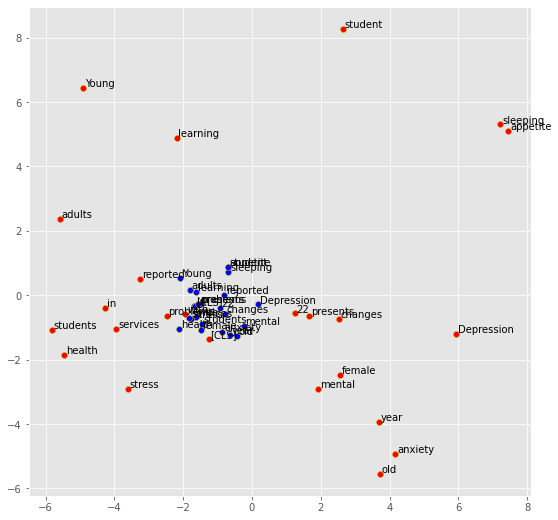

In [24]:
#display_pca_scatterplot(layers[0], tokens_selected)
#display_pca_scatterplot(layers[-1], tokens_selected)
display_pca_scatterplot_compare(layers[0], layers[-1], tokens_selected)

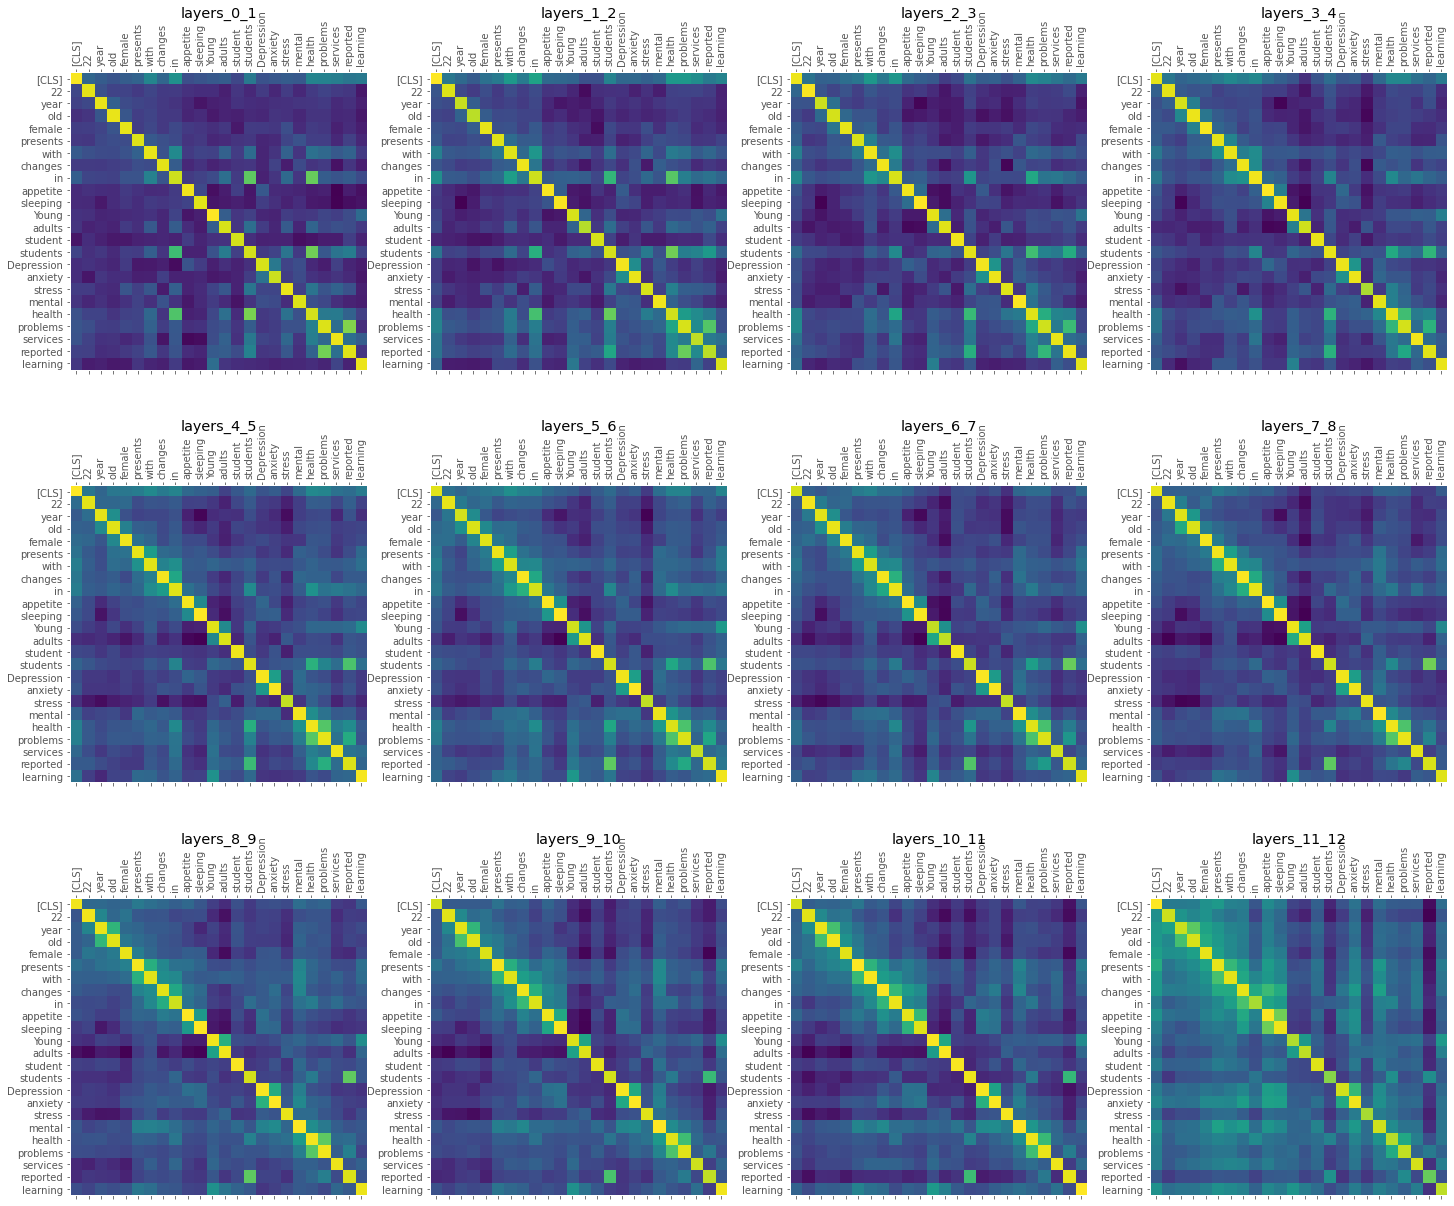

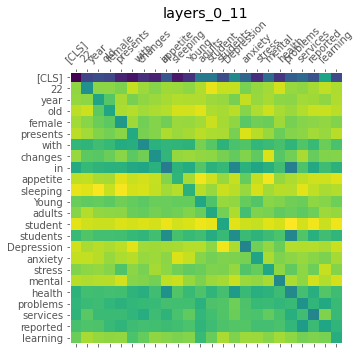

In [25]:
from sklearn.metrics.pairwise import pairwise_distances

attention_matrix = []

labels = []
for t in tokens_selected:
    labels.append(t)

fig, ax = plt.subplots(3, 4, figsize=(20,20))

for i in range (12):
    attention_matrix = 1 - pairwise_distances(layers[i], layers[i+1], metric='cosine')
    #attention_matrix = attention_matrix.round(1)
    row = int(i / 4)
    col = i % 4
    
    cax = ax[row, col].matshow(attention_matrix)
    ax[row, col].grid(False)
    ax[row, col].set_title('layers_' + str(i) + "_" + str(i+1), pad=40)
    #print('head_' + str(i))
    plt.sca(ax[row, col])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);

#fig.colorbar(cax, ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
fig.tight_layout(pad=0.0)
fig.subplots_adjust(hspace=-0.3)
fig.savefig("similarity_plots" + ("_nrel" if non_relevant else "") + ".png")
plt.show()

attention_matrix = pairwise_distances(layers[0], layers[-1], metric='cosine')
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(attention_matrix)
ax.grid(False)
ax.set_title('layers_0_11', pad=40)
plt.sca(ax)
plt.xticks(range(len(labels)), labels, rotation=45);
plt.yticks(range(len(labels)), labels);
fig.savefig("similarity_plot_changes" + ("_nrel" if non_relevant else "") + ".png")
plt.show()

In [26]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [27]:
outputs = model(**inputs_query_passages)
attention = outputs['attentions']

In [28]:
extracted_attention_matrix = torch.empty(12, 1, 12, len(tokens_selected), len(tokens_selected))
for l, layer in enumerate(attention):
    for h, head in enumerate(layer[0]):
        temp = attention[l][0][h][indexes]
        for t1, tokens1 in enumerate(temp):
            extracted_attention_matrix[l, 0, h, t1] = tokens1[indexes]    
        #print(attention2[l, 0, h].shape)
print(extracted_attention_matrix.size())

torch.Size([12, 1, 12, 24, 24])


In [29]:
call_html()
head_view(extracted_attention_matrix, tokens_selected)
model_view(extracted_attention_matrix, tokens_selected)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>